In [ ]:
import numpy as np
import pandas as pd
from PIL import Image


In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
from tensorflow.keras.applications import DenseNet121

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import statistics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/MLHW4/HW4_data.zip" # FILE PATH

In [ ]:
X_train = []
for i in range(10000):
    X_train.append(np.asarray(Image.open("HW4_data/public/train_{i}.jpg".format(i=i))))

df_train = pd.read_csv("HW4_data/public/train_label.csv", index_col=0)

In [ ]:
X_val = []
for i in range(1000):
    X_val.append(np.asarray(Image.open("HW4_data/public/val_{i}.jpg".format(i=i))))

df_val = pd.read_csv("HW4_data/public/val_label.csv", index_col=0)

In [ ]:
X_test = []
for i in range(1500):
    X_test.append(np.asarray(Image.open("HW4_data/private/test_{i}.jpg".format(i=i))))

df_test_demo = pd.read_csv("HW4_data/private/test_demo.csv", index_col=0)

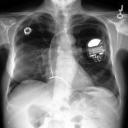

train_0.jpg


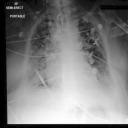

train_1.jpg


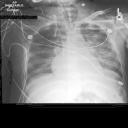

train_2.jpg


In [ ]:
import IPython.display as display
for i in range(3):
    image_path = "HW4_data/public/train_"+ str(i) +".jpg"
    display.display(display.Image(image_path, width=128, height=128))
    print(image_path.split('/')[-1])

In [ ]:
X_trainnormal = X_train
for i in range(10000):
  X_trainnormal[i] = X_train[i]/255.0

X_valnormal = X_val
for i in range(1000):
  X_valnormal[i] = X_val[i]/255.0

X_testnormal = X_test
for i in range(1500):
  X_testnormal[i] = X_test[i]/255.0

In [ ]:
xtrain = np.array(X_trainnormal)
xval = np.array(X_valnormal)
xtest = np.array(X_testnormal)

In [ ]:
xtrain.shape

(10000, 128, 128)

In [ ]:
xtrain[0]

array([[0.00784314, 0.00784314, 0.00784314, ..., 0.        , 0.01960784,
        0.02352941],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.        , 0.        ,
        0.        ],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02352941, 0.03137255,
        0.01568627],
       ...,
       [0.        , 0.        , 0.03529412, ..., 0.00392157, 0.00392157,
        0.01568627],
       [0.        , 0.        , 0.03137255, ..., 0.        , 0.00392157,
        0.01568627],
       [0.00392157, 0.        , 0.03137255, ..., 0.        , 0.00392157,
        0.01568627]])

In [ ]:
ytrain = df_train.drop(['Age', 'Gender'], axis=1)
yval = df_val.drop(['Age', 'Gender'], axis=1)

In [ ]:
xtrain = np.repeat(xtrain[..., np.newaxis], 3, -1)



In [ ]:
xval = np.repeat(xval[..., np.newaxis], 3, -1)

In [ ]:
xtest = np.repeat(xtest[..., np.newaxis], 3, -1)

In [ ]:
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(7, activation='sigmoid')

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 7175      
                                                                 
Total params: 7,044,679
Trainable params: 7,175
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(xtrain, ytrain,
                    epochs=10,
                    batch_size=70,
                    validation_data=(xval, yval))

Epoch 1/10
143/143 [==============================] - 496s 3s/step - loss: 0.5515 - accuracy: 0.5705 - val_loss: 0.4077 - val_accuracy: 0.6960
Epoch 2/10
143/143 [==============================] - 489s 3s/step - loss: 0.3946 - accuracy: 0.6812 - val_loss: 0.3783 - val_accuracy: 0.7010
Epoch 3/10
143/143 [==============================] - 486s 3s/step - loss: 0.3700 - accuracy: 0.6812 - val_loss: 0.3640 - val_accuracy: 0.6900
Epoch 4/10
143/143 [==============================] - 487s 3s/step - loss: 0.3571 - accuracy: 0.6826 - val_loss: 0.3552 - val_accuracy: 0.6920
Epoch 5/10
143/143 [==============================] - 484s 3s/step - loss: 0.3488 - accuracy: 0.6855 - val_loss: 0.3488 - val_accuracy: 0.6930
Epoch 6/10
143/143 [==============================] - 486s 3s/step - loss: 0.3432 - accuracy: 0.6875 - val_loss: 0.3443 - val_accuracy: 0.6920
Epoch 7/10
143/143 [==============================] - 486s 3s/step - loss: 0.3389 - accuracy: 0.6908 - val_loss: 0.3414 - val_accuracy: 0.6940

In [ ]:
results = model.evaluate(xval, yval, verbose=0)

In [ ]:
model.save("HW4advanceddense.h5")

In [ ]:
results


[0.334206759929657, 0.6940000057220459]

In [ ]:
output = model.predict(xval)

In [ ]:
output

array([[0.10152   , 0.07648587, 0.21358421, ..., 0.72317994, 0.0522767 ,
        0.12856859],
       [0.00570258, 0.01033804, 0.04131529, ..., 0.93736756, 0.009588  ,
        0.09827501],
       [0.01238489, 0.00922069, 0.02200192, ..., 0.96699053, 0.03016597,
        0.06975526],
       ...,
       [0.3276352 , 0.05946761, 0.5898332 , ..., 0.43976367, 0.55463135,
        0.82299984],
       [0.01280257, 0.01181161, 0.26858765, ..., 0.8424927 , 0.01195288,
        0.46649712],
       [0.15650094, 0.4359925 , 0.63168156, ..., 0.28174764, 0.4746308 ,
        0.5749887 ]], dtype=float32)

In [ ]:
output.shape[1]

7

In [ ]:
output[7]

array([0.09468561, 0.27597058, 0.6485879 , 0.37338203, 0.1325503 ,
       0.5439242 , 0.7835506 ], dtype=float32)

In [ ]:
yvalpred = np.where(output > 0.2, 1, 0)


In [ ]:
yvalpred

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [ ]:
dfyval = pd.DataFrame(yval)
dfyval

,Atelectasis,Cardiomegaly,Edema,Lung Opacity,No Finding,Pleural Effusion,Support Devices
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,1,0,1,1,0,1,1
4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,1
996,0,0,0,0,1,0,0
997,0,0,1,0,0,0,1
998,0,0,0,0,1,0,1


In [ ]:
dfyvalpred = pd.DataFrame(yvalpred)

In [ ]:
dfyvalpred

,0,1,2,3,4,5,6
0,0,0,1,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,1,0,1,0,1
4,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,0
996,0,0,1,1,1,0,1
997,1,0,1,1,1,1,1
998,0,0,1,0,1,0,1


In [ ]:
ypred = model.predict(xtest)


In [ ]:
ypred = np.where(ypred > 0.3, 1, 0)

In [ ]:
import sklearn

In [ ]:
f1 = f1_score(y_true=dfyval, y_pred=dfyvalpred, average='weighted')

In [ ]:
f1

0.6584358998603834

In [ ]:
ypred.shape[1]

7

In [ ]:
dfpred = pd.DataFrame(ypred)

In [ ]:
output_path = '108062172_advanced_prediction.csv'
test_pred = pd.DataFrame( {'Atelectasis':dfpred[:][0], 'Cardiomegaly':dfpred[:][1], 'Edema':dfpred[:][2], 'Lung Opacity':dfpred[:][3], 'No Finding':dfpred[:][4], 'Pleural Effusion':dfpred[:][5], 'Support Devices':dfpred[:][6],} )
test_pred.to_csv(output_path, index = True)